In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
print('Numpy:', np.__version__)
print('Pandas:', pd.__version__)
print('Tensorflow:', tf.__version__)
print('Seaborn:', sns.__version__)

Numpy: 1.19.5
Pandas: 1.4.4
Tensorflow: 2.4.0
Seaborn: 0.12.0


In [4]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
dataset= pd.read_csv("all_anonymized_2015_11_2017_03.csv", low_memory=False)

In [6]:
df=dataset
len(df)

3552912

There are roughly 3.5 Million rows and the following columns:

maker - normalized all lowercase\
model - normalized all lowercase\
mileage - in KM\
manufacture_year\
engine_displacement - in ccm\
engine_power - in kW\
body_type - almost never present, only personal cars, no motorcycles or utility vehicles\
color_slug - also almost never present\
stk_year - year of the last emission control\
transmission - automatic or manual\
door_count\
seat_count\
fuel_type - gasoline, diesel, cng, lpg, electric\
date_created - when the ad was scraped\
datelastseen - when the ad was last seen. Our policy was to remove all ads older than 60 days\
price_eur - list price converted to EUR\

## Drop rows with Target (price_eur) >30K euros

In [7]:
df['price_eur'].describe()

count    3.552912e+06
mean     1.625812e+06
std      2.025622e+09
min      4.000000e-02
25%      1.295340e+03
50%      7.364910e+03
75%      1.628423e+04
max      2.706149e+12
Name: price_eur, dtype: float64

We can see that the price is upto 2706 billion euro. We select the price more than third quartile. Say 30000 euros.

In [8]:
df.drop(df[df['price_eur']>30000].index,inplace=True)
len(df)

3304733

In [9]:
df['price_eur'].describe()

count    3.304733e+06
mean     8.684976e+03
std      7.863996e+03
min      4.000000e-02
25%      1.295340e+03
50%      6.254630e+03
75%      1.400244e+04
max      3.000000e+04
Name: price_eur, dtype: float64

<AxesSubplot:>

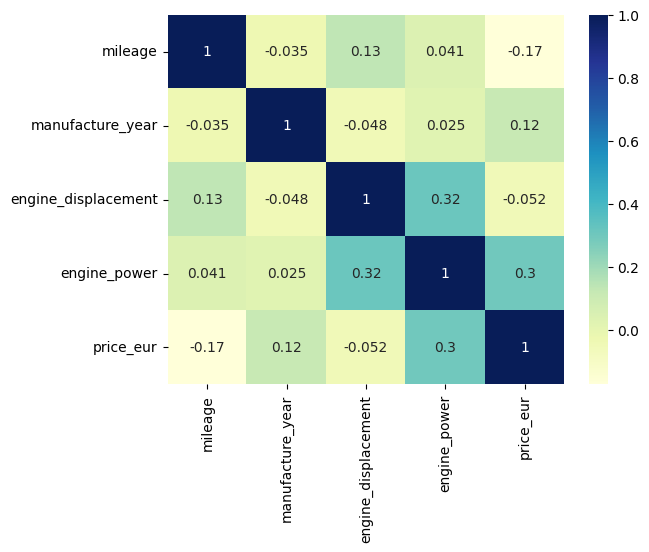

In [10]:
df.corr()

sns.heatmap(df.corr(),cmap="YlGnBu",annot=True)

## Data Description (count, mean, std, min, quartile, max)

In [11]:
df.describe()

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,2.945925e+06,2.978823e+06,2.598318e+06,2.765644e+06,3.304733e+06
mean,1.230285e+05,2.000128e+03,1.990987e+03,9.174355e+01,8.684976e+03
std,3.536525e+05,8.425185e+01,2.014926e+03,3.864475e+01,7.863996e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e-02
25%,2.398000e+04,2.004000e+03,1.396000e+03,6.600000e+01,1.295340e+03
50%,9.511000e+04,2.009000e+03,1.685000e+03,8.500000e+01,6.254630e+03
75%,1.640000e+05,2.013000e+03,1.995000e+03,1.070000e+02,1.400244e+04
max,9.999999e+06,2.017000e+03,3.276700e+04,2.237000e+03,3.000000e+04


We can see that the dataset has instances with mileage and manufacture year equals Zero i.e. the dataset needs to be cleaned

## Missing data in each column

In [12]:
print('No of samples: ', len(df))
df.isna().sum()

No of samples:  3304733


maker                   499163
model                  1008641
mileage                 358808
manufacture_year        325910
engine_displacement     706415
engine_power            539089
body_type              1023084
color_slug             3097141
stk_year               1601681
transmission            731944
door_count              601544
seat_count              715309
fuel_type              1704583
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64

We can see we have 3.5 million samples. we will be dropping columns with 30% NaN i.e. more than 1.05 million NaN samples, which are model,body_type,color_slug, stk_year, fuel_type, date_created and date_last_seen

In [13]:
columns=['color_slug',"model","body_type","color_slug", "stk_year", "fuel_type","date_created", "date_last_seen"]
df.drop(columns=columns,inplace=True)

In [14]:
df['transmission'].value_counts()

man     1977223
auto     595566
Name: transmission, dtype: int64

## Data type of each column

In [15]:
df.dtypes

maker                   object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
transmission            object
door_count              object
seat_count              object
price_eur              float64
dtype: object

In [16]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(df, title="Pandas Profiling Report")


# Local shows error in the panda profiling

## Drop rows with more than 4 NaN


In [17]:
df.drop(df[(df.isnull().sum(axis=1)>4)==True].index, inplace=True)

## Manufacturer ('maker')
### Fill NaN with mode of maker

In [18]:
# profile

In [19]:
df['maker'].replace(np.nan, df['maker'].mode()[0], inplace=True)
len(df)

3022461

In [20]:
df['maker'].isnull().sum()

0

## Seat Count and Door Count
### Keep cars with 10>=Seats >=1 and 6>=Doors>=1 and drop remaining

In [21]:
df['door_count'].value_counts()

4       1017827
5        835995
None     403434
2        264662
3        118109
0          7897
6          1169
1           261
7            38
55            9
9             4
8             3
58            3
54            1
77            1
22            1
45            1
17            1
49            1
Name: door_count, dtype: int64

Replace None with nan. \
Fill nan with median because of skewness. \
We convert floating value to integer value.

In [22]:
df['door_count'].replace('None', np.nan, inplace=True)
df['seat_count'].replace('None', np.nan, inplace=True)

In [23]:
print('Average Seat: ', df['seat_count'].median(), '\nAverage Door: ', df['door_count'].median())

Average Seat:  5.0 
Average Door:  4.0


In [24]:
df['seat_count'] = df['seat_count'].fillna(df['seat_count'].median()).astype(str).astype(float).astype(int)
df['door_count'] = df['door_count'].fillna(df['door_count'].median()).astype(str).astype(float).astype(int)

In [25]:
scount_ind = df[((df['seat_count']>10) | (df['seat_count']<1))].index
df.drop(scount_ind,inplace=True)

dcount_ind = df[((df['door_count']>6) | (df['door_count']<1))].index
df.drop(dcount_ind,inplace=True)
len(df)

3007487

<AxesSubplot:xlabel='door_count'>

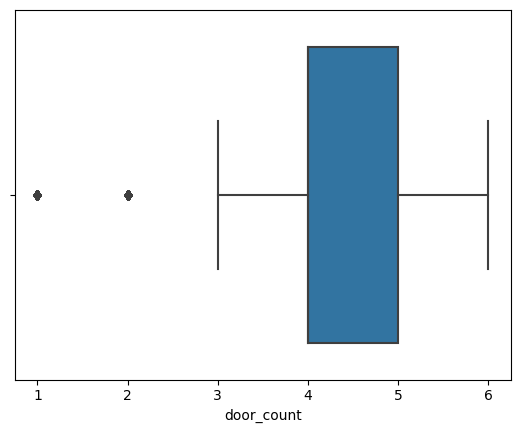

In [26]:
sns.boxplot(x=df['door_count'])

<AxesSubplot:xlabel='seat_count'>

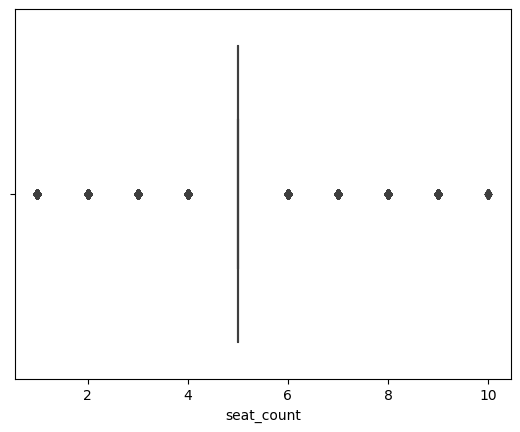

In [27]:
sns.boxplot(x=df['seat_count'])

In [28]:
sns.scatterplot(df['seat_count'],df['door_count'])

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

The dataset has cars with 1 seat and 5 doors which is not possible. We drop the samples with door count twice of seat count.

## Remove samples with door_count>2\*seat_count

In [28]:
d_greater_s_ind=df.loc[(df['door_count']>2*df['seat_count'])].index
print('No of cars with the number of doors twice the number seats:',len(d_greater_s_ind))
df.drop(d_greater_s_ind, inplace=True)

No of cars with the number of doors twice the number seats: 2757


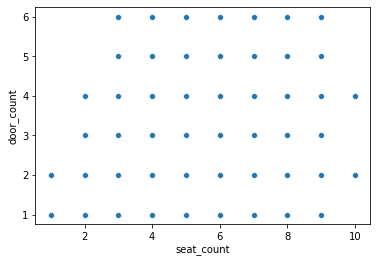

In [29]:
sns.scatterplot(df['seat_count'],df['door_count'])

In [30]:
print(df['seat_count'].isnull().sum(),df['door_count'].isnull().sum())

0 0


## Manufacture Year

### Drop samples with manufacture_year < 1967 i.e. select cars from last 50 years


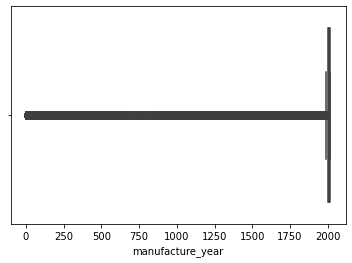

In [31]:
sns.boxplot(x=df['manufacture_year'])

In [32]:
myear_ind = df[df['manufacture_year']<1967].index
df.drop(myear_ind,inplace=True)

In [33]:
df['manufacture_year'].replace(np.nan, df['manufacture_year'].median(), inplace=True)
len(df)

2974507

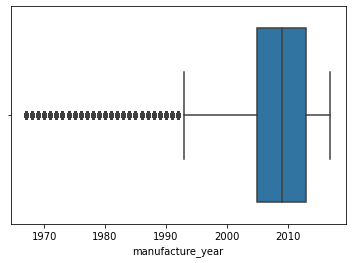

In [34]:
sns.boxplot(x=df['manufacture_year'])

In [35]:
df['manufacture_year'].isnull().sum()

0

## Engine Displacement
### Drop rows with engine_displacement>10000

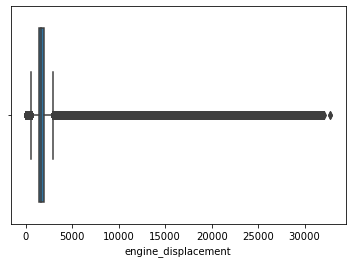

In [36]:
sns.boxplot(x=df['engine_displacement'])

In [37]:
df.loc[df['engine_displacement']>10000]

,maker,mileage,manufacture_year,engine_displacement,engine_power,transmission,door_count,seat_count,price_eur
3361,skoda,101127.0,1998.0,12859.0,50.0,man,5,5,592.15
9999,citroen,99300.0,2003.0,25020.0,NaN,NaN,4,5,1369.36
10002,mazda,140700.0,2007.0,27020.0,NaN,auto,4,5,5070.32
10007,skoda,NaN,2010.0,10400.0,NaN,NaN,4,5,4404.15
10041,skoda,108000.0,2015.0,17600.0,110.0,auto,4,5,12694.30
...,...,...,...,...,...,...,...,...,...
3551623,audi,257000.0,1999.0,31900.0,82.0,auto,4,5,1295.34
3551754,ford,250000.0,2003.0,31900.0,85.0,NaN,4,5,1295.34
3552099,volkswagen,280000.0,2009.0,31900.0,66.0,NaN,4,5,1295.34
3552423,volkswagen,134000.0,2002.0,12200.0,37.0,NaN,4,5,1295.34


In [38]:
df['engine_displacement'].replace(np.nan, df['engine_displacement'].median(), inplace=True)
edisp_ind = df[df['engine_displacement']>10000].index
df.drop(edisp_ind,inplace=True)
len(df)

2955052

### Fill NaN engine_displacement with median

In [39]:
df['engine_displacement'].replace(np.nan,df['engine_displacement'].median(), inplace=True)

In [40]:
df['engine_displacement'].isnull().sum()

0

## Mileage
### Fill NaN mileage with median

In [41]:
# Assuming blunder in data collection. We replace 0.0 mileage with median mileage value. 
# Then we drop cars with mileage less than 100 km.

df['mileage'].replace(np.nan,df['mileage'].median(), inplace=True)
# df['mileage'].replace(0.0, df['mileage'].median(), inplace=True)
mile_ind = df[df['mileage']<100].index
df.drop(mile_ind,inplace=True)

len(df)

2636874

In [42]:
df['mileage'].isnull().sum()

0

## Mode of transmission
### Fill NaN value with mode of transmission

In [43]:
df['transmission'].replace(np.nan,df['transmission'].mode()[0], inplace=True)
df['transmission'].value_counts()

man     2106621
auto     530253
Name: transmission, dtype: int64

# Plotting

In [44]:
df['price_eur'].value_counts()

1295.34     453227
10900.00      6311
9900.00       6274
12900.00      6034
11900.00      5813
             ...  
11505.00         1
14200.63         1
11503.00         1
14182.38         1
9962.47          1
Name: price_eur, Length: 125991, dtype: int64

In [45]:
df['price_eur'].describe()

count    2.636874e+06
mean     8.578610e+03
std      7.546680e+03
min      4.000000e-02
25%      1.600670e+03
50%      6.400700e+03
75%      1.349437e+04
max      3.000000e+04
Name: price_eur, dtype: float64

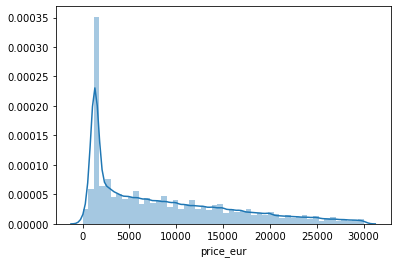

In [46]:
sns.histplot(df["price_eur"])

## Correlation Heatmap of cleaned dataset

<AxesSubplot:>

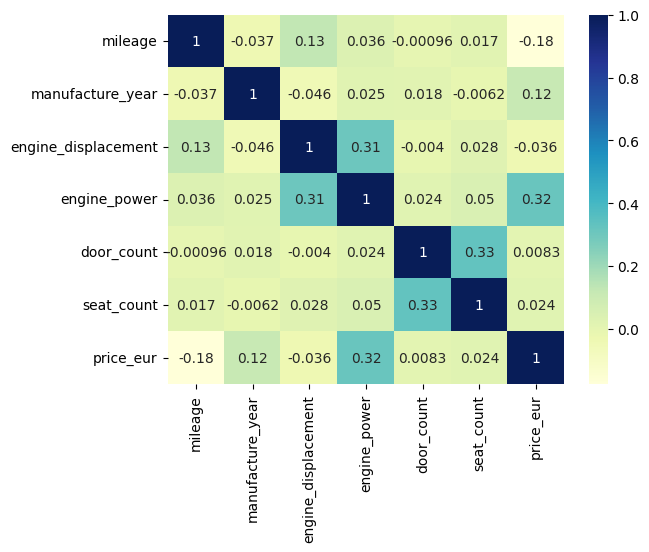

In [29]:
corr = df.corr()
sns.heatmap(corr,cmap="YlGnBu", annot=True)

<AxesSubplot:xlabel='engine_power', ylabel='engine_displacement'>

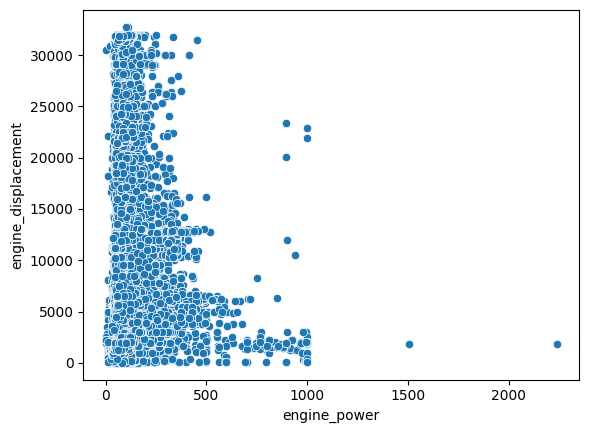

In [30]:
sns.scatterplot(x=df['engine_power'],y=df['engine_displacement'])

<AxesSubplot:xlabel='door_count', ylabel='seat_count'>

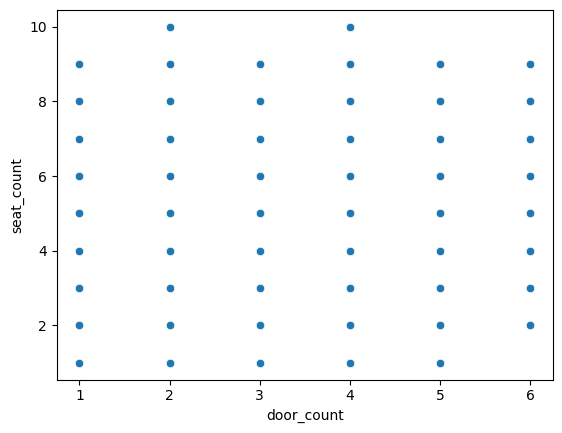

In [31]:
sns.scatterplot(x=df['door_count'],y=df['seat_count'])

<AxesSubplot:xlabel='mileage', ylabel='price_eur'>

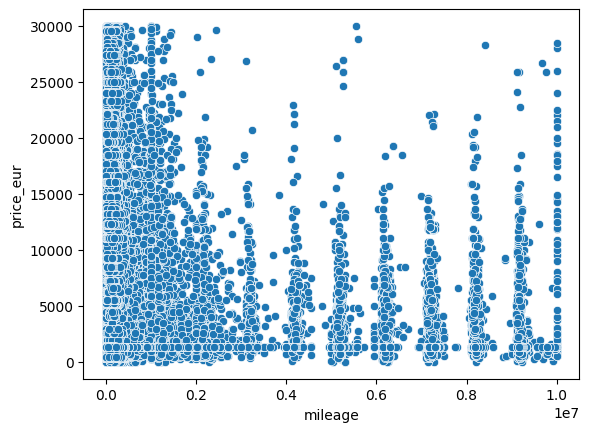

In [32]:
sns.scatterplot(x=df['mileage'],y=df['price_eur'])

The plots above don't give much information. We plot the logarithmic transformation to intrepret the dataset.

## Logarithmic Transformation and Intrepretation

In [33]:
df_new=df.copy()

### Mileage

<AxesSubplot:xlabel='mileage', ylabel='Density'>

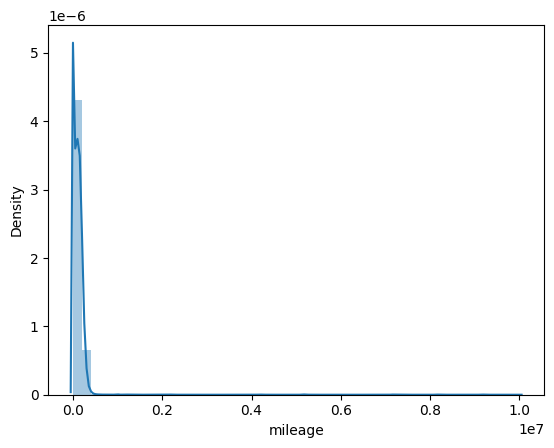

In [ ]:
sns.histplot(df['mileage'])

<AxesSubplot:xlabel='mileage', ylabel='Count'>

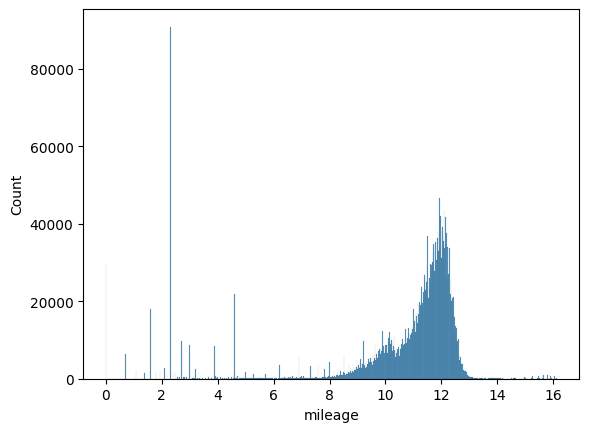

In [37]:
df_new['mileage']=np.log(df['mileage'])
sns.histplot(df_new['mileage'])

<AxesSubplot:xlabel='mileage', ylabel='Count'>

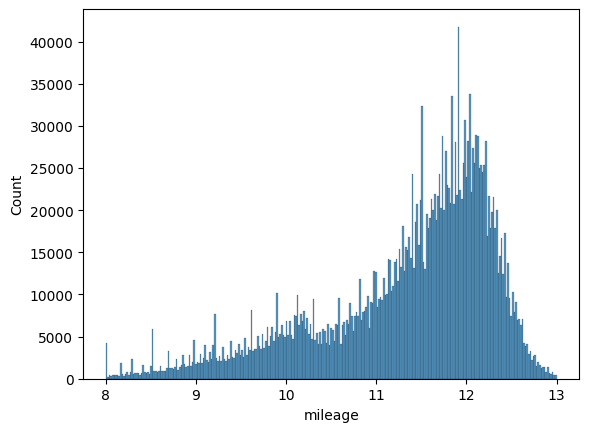

In [38]:
# Select samples from the log graph within the distribution
df_new = df_new[(df_new['mileage']>8)&(df_new['mileage']<13)]
sns.histplot(df_new['mileage'])

### Engine Power

<AxesSubplot:xlabel='engine_power', ylabel='Count'>

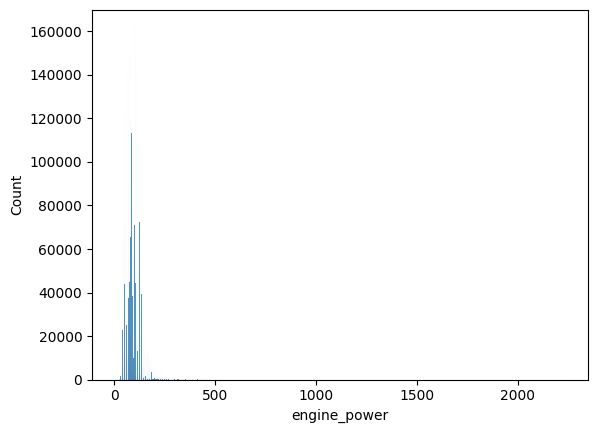

In [39]:
sns.histplot(df['engine_power'])

<AxesSubplot:xlabel='engine_power', ylabel='Count'>

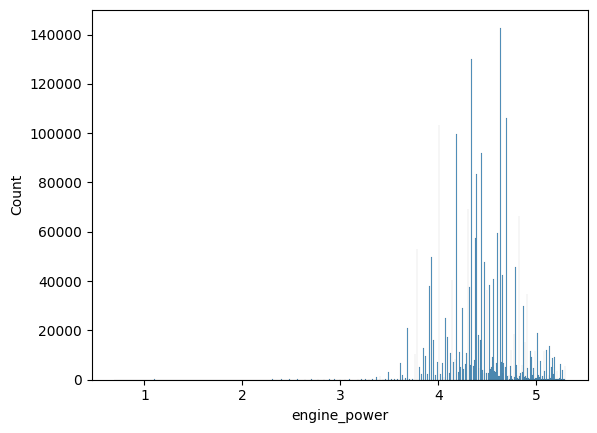

In [40]:
df_new['engine_power']=np.log(df['engine_power'])

# Select samples from the original dataset within the distribution
df_new= df_new[(df_new['engine_power']>0)&(df_new['engine_power']<5.3)]
sns.histplot(df_new['engine_power'])

### Engine Displacement

<AxesSubplot:xlabel='engine_displacement', ylabel='Count'>

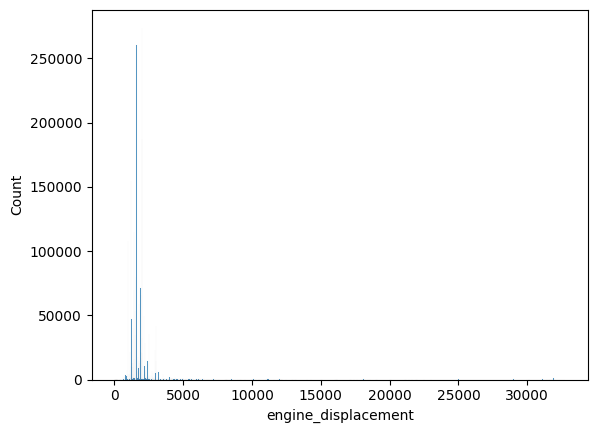

In [41]:
sns.histplot(df['engine_displacement'])

<AxesSubplot:xlabel='engine_displacement', ylabel='Count'>

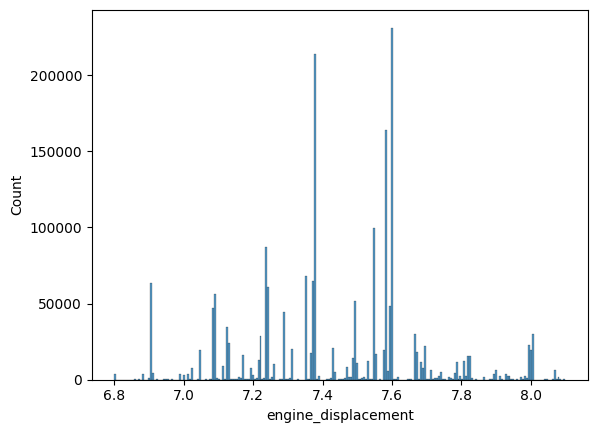

In [42]:
df_new['engine_displacement']=np.log(df['engine_displacement'])

# Select samples from the range of log distribution graph
df_new= df_new[(df_new['engine_displacement']>6.8)&(df_new['engine_displacement']<8.1)]
sns.histplot(df_new['engine_displacement'])

### Manufacture Year

<AxesSubplot:xlabel='manufacture_year', ylabel='Count'>

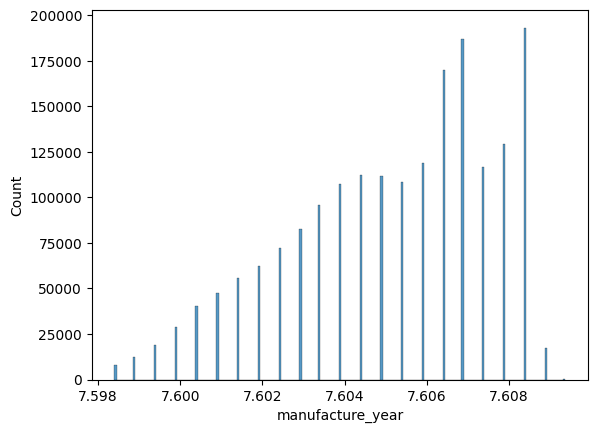

In [43]:
df_new['manufacture_year']=np.log(df['manufacture_year'])

# Select samples from the range of log distribution graph
df_new= df_new[(df_new['manufacture_year']>7.598)&(df_new['manufacture_year']<7.610)]
sns.histplot(df_new['manufacture_year'])

## Other features

### Transmission type with engine power, engine displacement, mileage and price_eur 

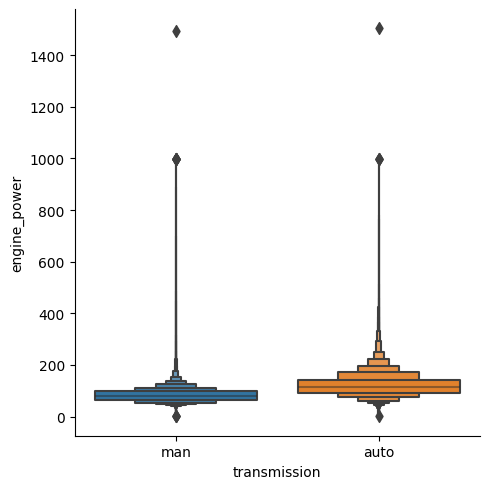

In [44]:
sns.catplot(x="transmission", y="engine_power", kind="boxen", data=df)

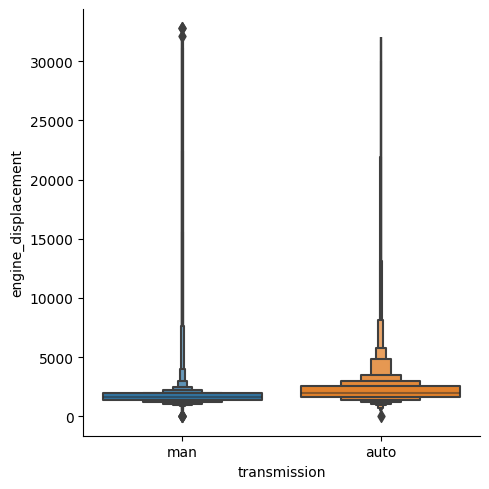

In [45]:
sns.catplot(x="transmission", y="engine_displacement", kind="boxen", data=df)

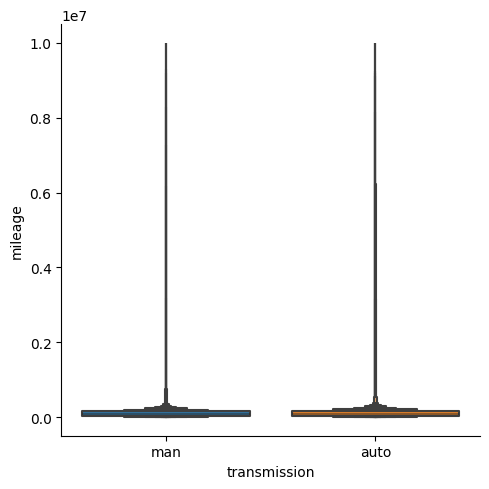

In [46]:
sns.catplot(x="transmission", y="mileage", kind="boxen", data=df)

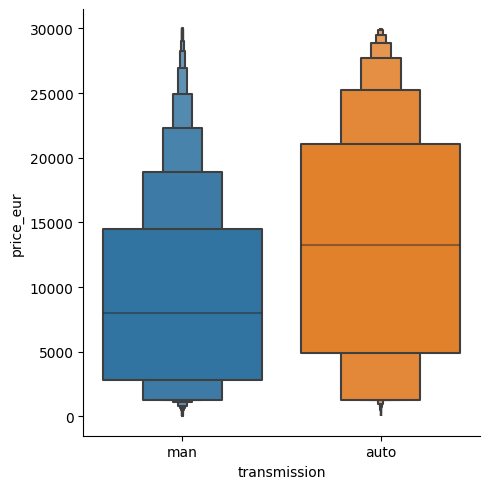

In [47]:
sns.catplot(x="transmission", y="price_eur", kind="boxen", data=df)

Automatic cars are expensive and have a little more engine displacement than manual cars.

### Average Mileage by car manufacturer

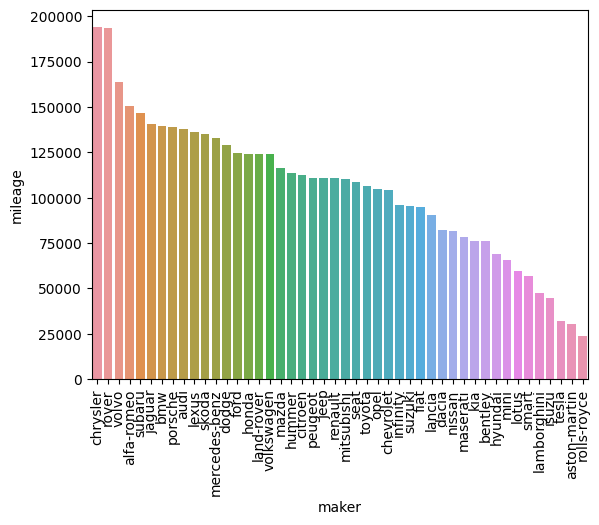

In [49]:

# Group by 'maker' and calculate mean mileage
grouped = dataset.groupby(['maker'])
maker_mileage = grouped['mileage'].agg(np.mean).sort_values(ascending=False)
maker_mileage_df = maker_mileage.reset_index()

# Create barplot using keyword arguments
ax = sns.barplot(x='maker', y='mileage', data=maker_mileage_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Show plot
plt.show()


Rover have more mileage and Rolce-Royce have less mileage compared to other manufactures. 

### Top 20 car manufacturers in the dataset

In [50]:
maker_df=df['maker'].value_counts().reset_index()[:30]

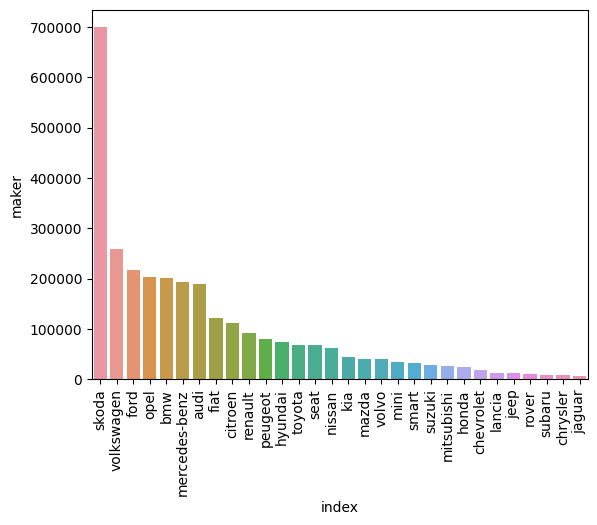

In [53]:
ax = sns.barplot(x='index', y='maker', data=maker_df)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [54]:
top_20_maker=df[df['maker'].isin(maker_df['index'].ravel())]

### Price distribution by manufacturer (Top 20)

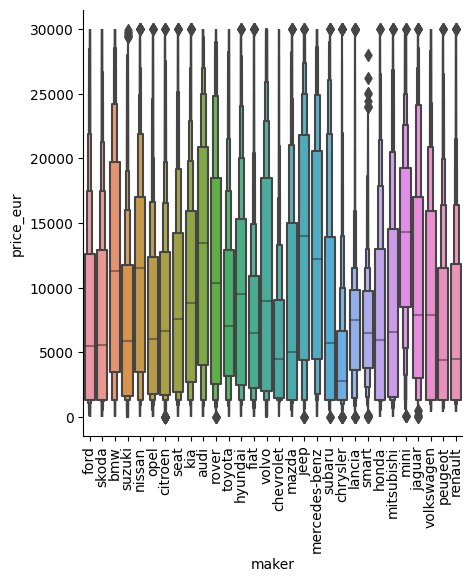

In [55]:
ax=sns.catplot(x="maker", y="price_eur", kind="boxen", data=top_20_maker)
ax.set_xticklabels(rotation=90)
plt.show()